In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=eabfc9afcf9fad6ee63b55d34e335a750b62ac8b6421746e6781acaf01befcf2
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
! pip install matplotlib
! pip install seaborn

Mean Squared Error (MSE): 0.007204820474657998
R-squared (R2): 0.9999878577178806


<Figure size 1200x600 with 0 Axes>

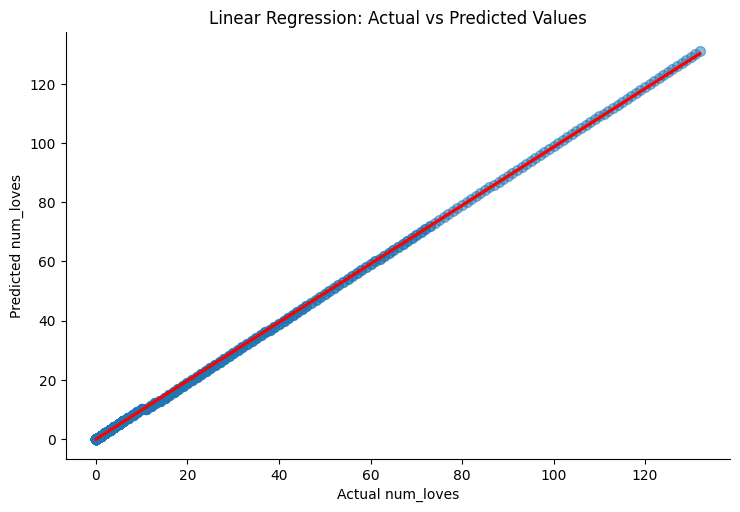

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, desc
import seaborn as sns
import matplotlib.pyplot as plt

#Linear

# Linear Regression Pipeline Example
# สร้าง SparkSession เพื่อใช้ในการทำงานกับ PySpark
spark = SparkSession.builder \
    .appName("LinearRegressionPipelineExample") \
    .getOrCreate()

# ขั้นตอนที่ 2: โหลดข้อมูลจากไฟล์ CSV ลงใน DataFrame
data = spark.read.csv('fb_live_thailand.csv', header=True, inferSchema=True)

# ขั้นตอนที่ 3: ใช้ StringIndexer เพื่อเตรียมข้อมูล
# แปลงคอลัมน์ num_reactions เป็นค่าที่เป็นตัวเลข
indexer_reactions = StringIndexer(inputCol="num_reactions", outputCol="num_reactions_ind")
# แปลงคอลัมน์ num_loves เป็นค่าที่เป็นตัวเลข
indexer_loves = StringIndexer(inputCol="num_loves", outputCol="num_loves_ind")

# ขั้นตอนที่ 4: ใช้ VectorAssembler เพื่อสร้างเวกเตอร์ฟีเจอร์
assembler = VectorAssembler(
    inputCols=["num_reactions_ind", "num_loves_ind"],
    outputCol="features"
)

# ปรับค่า โมเดล
# ขั้นตอนที่ 5: กำหนดโมเดล Linear Regression
lr = LinearRegression(
    featuresCol="features",
    labelCol="num_loves_ind",
    maxIter=10,         # จำนวนรอบการฝึกฝน
    regParam=0.1,       # พารามิเตอร์การลดความซับซ้อน
    elasticNetParam=0.8 # ค่าที่ใช้ในการควบคุมระหว่าง L1 และ L2 regularization
)

# ขั้นตอนที่ 6: สร้าง Pipeline ด้วยแต่ละขั้นตอน
# ไม่รวม indexer_reactions และ indexer_loves ใน pipeline
pipeline = Pipeline(stages=[assembler, lr])

# ขั้นตอนที่ 7: แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# ขั้นตอนที่ 8: ฝึกโมเดลด้วยชุดฝึก
# ใช้ StringIndexers เพื่อแปลงข้อมูลในชุดฝึก
train_data = indexer_reactions.fit(train_data).transform(train_data)
train_data = indexer_loves.fit(train_data).transform(train_data)
pipeline_model = pipeline.fit(train_data)

# ขั้นตอนที่ 9: แปลงข้อมูลชุดทดสอบด้วยโมเดล pipeline
# ใช้ StringIndexers เพื่อแปลงข้อมูลในชุดทดสอบ
test_data = indexer_reactions.fit(test_data).transform(test_data)
test_data = indexer_loves.fit(test_data).transform(test_data)
predictions = pipeline_model.transform(test_data)

# ขั้นตอนที่ 10: สร้าง RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="num_loves_ind",
    predictionCol="prediction"
)

# MSE ใกล้เคียงกับ 0 ดีสุด
# ประเมิน Mean Squared Error (MSE)
evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

# R2 ใกล้เคียงกับ 1 ดีสุด
# ประเมิน R-squared (R2)
evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared (R2): {r2}")

# ขั้นตอนที่ 11: เลือกคอลัมน์และแปลงประเภท, เรียงลำดับตาม 'prediction' ในลำดับลดลง
selected_data = predictions.select(
    col("num_loves_ind").cast(IntegerType()).alias("num_loves"),
    col("prediction").cast(IntegerType()).alias("prediction")
).orderBy(col("prediction").desc())

# แปลงเป็น Pandas DataFrame สำหรับการวิเคราะห์เพิ่มเติม
selected_data_pd = selected_data.toPandas()

# ขั้นตอนที่ 12: การสร้างกราฟโดยใช้ Seaborn's lmplot
plt.figure(figsize=(12, 6))
sns.lmplot(
    data=selected_data_pd,
    x='num_loves',
    y='prediction',
    aspect=1.5,  # สัดส่วนของกราฟ
    scatter_kws={'s': 50, 'alpha': 0.5},  # กำหนดคุณสมบัติของจุดในกราฟ
    line_kws={'color': 'red'}  # กำหนดคุณสมบัติของเส้นในกราฟ
)

plt.title('Linear Regression: Actual vs Predicted Values') # ชื่อกราฟ
plt.xlabel('Actual num_loves') # ชื่อแกน x
plt.ylabel('Predicted num_loves') # ชื่อแกน y
plt.show() # แสดงกราฟ

# หยุด SparkSession
spark.stop()